# Modeling

## Vectorize

To detect similarities between series episodes, we need to choose a word representation method. In my case TFIDF was used, because I wanted to reduce the importance of words that were used in most of the documents/scripts.

In [13]:
# import sklearn feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

In [14]:
# select TFIDF model
model = TfidfVectorizer()
v = model.fit_transform(df.script)

Below we can see the shape of the vector that was created.


(number of episodes X number of words in all documents)

In [15]:
v.shape

(403, 35568)

# Data Exploration

From here beyond, I will do some data analysis and data exploration to understand the data set

## Topic Extraction with NMF 
non-negative matrix factorization (multivariate analysis)

Here I will use NMF to discover the number of topics that provide an efficient representation of the original scripts.

In [16]:
from sklearn.decomposition import NMF

**set the number of topics**


in this case I analyzed different number of topics and determined that 10 was a best representation of the data

In [35]:
m2 = NMF(n_components=10)    # model selection
dt = m2.fit_transform(v)     # fit model using TFIDF matrix

In [36]:
dt[0]

array([0.        , 0.01062688, 0.0428151 , 0.01863602, 0.11922291,
       0.        , 0.02923828, 0.00287145, 0.00176396, 0.01863855])

We can see below that the first element of the **dt** array, has 10 values.


Each value represents one cluster/topic.


Below, I will take the maximum value of each episode and assigned to the respective dataframe row.

In [37]:
# create clusters for each episode from each series
df['cluster'] = dt.argmax(axis=1)

In [38]:
# the row 'cluster' is topic that the episode was assigned to
df.head(2)

,episode_name,header,script,season,serie_name,serie_name2,streaming_platform,category,cluster
0,The Enemies of my Enemy,Narcos (2015) s02e05 Episode Script,gotta fucking kidding mm...,Season 2,Narcos (2015),narcos,netflix,drama,4
1,Here Comes the Sun,Fuller House (2016) s03e18 Episode Script ...,1 whatever happened pred...,Season 3,Fuller House (2016),fuller house,netflix,comedy,0


**Feature Extraction Results**

Now it is time to plot the words that represents each topic, and analyze if it makes sense

In [40]:
# print the words for each topic
topic_words = []
words = model.get_feature_names()
for r in m2.components_:
    a = sorted([(v,i) for i,v in enumerate(r)],reverse=True)[0:7]        # print 7 most common words
    topic_words.append([words[e[1]] for e in a])

In [41]:
topic_words

[['get', 'well', 'go', 'god', 'mean', 'cant', 'sorry'],
 ['dr', 'robot', 'well', 'dear', 'get', 'professor', 'shall'],
 ['president', 'underwood', 'sir', 'well', 'mr', 'secretary', 'vice'],
 ['hefner', 'playboy', 'magazine', 'hef', 'bunnies', 'arnstein', 'club'],
 ['fucking', 'fuck', 'get', 'shit', 'well', 'go', 'man'],
 ['sighs', 'chuckles', 'music', 'man', 'laughs', 'door', 'get'],
 ['ngeles', 'alba', 'operator', 'aguilar', 'company', 'ill', 'go'],
 ['glinda', 'langwidere', 'toto', 'magic', 'ojo', 'scarecrow', 'gnomes'],
 ['clover', 'kingdom', 'majesty', 'foosa', 'xixi', 'ha', 'lemur'],
 ['bosch', 'waits', 'detective', 'go', 'get', 'gunn', 'mr']]

**Visualizing Topic Extraction**

In [42]:
# We can try to visualize our documents using TSNE - an approach for visualizing high-dimensional data

# Import the module first
from sklearn.manifold import TSNE

# And instantiate
tsne = TSNE()

# Let's try to boil down the 100 dimensions into 2
visualization = tsne.fit_transform(dt)

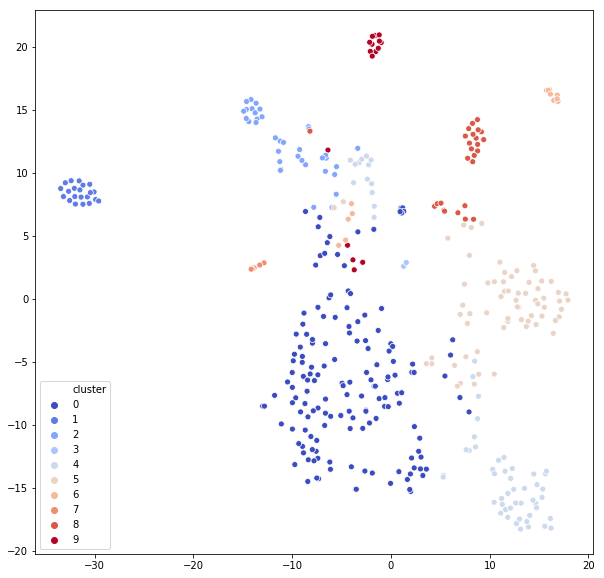

In [44]:
# Import plotting library
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,10))
sns.scatterplot(visualization[:,0],visualization[:,1], data = df, palette='coolwarm', hue=df['cluster'], legend='full')

# Clustering Series

**Defining a Cluster for Each Serie**

here I will find out in each cluster each series is inserted

on the above chart, each point represent an episode.

In [47]:
# pass the value NMF value from each cluster to each series
df['cluster2'] = list(dt)

In [85]:
# take the column with the cluster list for each series and tranform each value into a column
df_clustering = df
df_clustering = df_clustering.drop(columns=['episode_name', 'header', 'script', 'season','serie_name', 'category','cluster'])

This dataframe will only contain serie name, clusters value and streaming platform

In [86]:
df_clustering.head()

,serie_name2,streaming_platform,cluster2
0,narcos,netflix,"[0.0, 0.010626881124940021, 0.0428151011922099..."
1,fuller house,netflix,"[0.14914693976544746, 0.0026553386188518952, 0..."
2,bosch,amazon,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,mozart in the jungle,amazon,"[0.12471652180650052, 0.0015722685553084916, 0..."
4,big mouth,netflix,"[0.13552072026225975, 0.0027575293700355455, 0..."


In [87]:
df_clustering['c1'] = df_clustering['cluster2'].apply(lambda x: x[0])
df_clustering['c2'] = df_clustering['cluster2'].apply(lambda x: x[1])
df_clustering['c3'] = df_clustering['cluster2'].apply(lambda x: x[2])

In [88]:
df_clustering = df_clustering.drop(columns=['cluster2'])

# Groupby series name, find the mean to each cluster
df_serie = df_clustering.groupby(['serie_name2']).mean().reset_index()
df_serie['primary_cluster'] = df_serie[['c1', 'c2', 'c3']].idxmax(axis=1)

In [89]:
df_serie.head()

,serie_name2,c1,c2,c3,primary_cluster
0,13 reasons why,0.128819,0.003558,0.003692,c1
1,3%,0.015290,0.017320,0.022056,c3
2,alexa & katie,0.134405,0.000000,0.000000,c1
3,all about the washingtons,0.117917,0.005427,0.000000,c1
4,all hail king julien,0.009288,0.003648,0.002037,c1


# Creating Series Recommendations

Now we have a data frame with all Series, and we know in which topic/cluster it was inserted when using feature extraction.

The following step is to really analyze each series, and find its most similar series to recommend.

In [90]:
import numpy as np

# create a matrix with cluster values
a = np.matrix(df_serie[['c1', 'c2', 'c3']])

In [91]:
a.shape

(92, 3)

Here we have a tuple with 92 X 10 values, meaning that we have 92 series and 10 topics.

## Cosine Similarity

I used cosine similarity as a measure of similarity.

Cosine similarity values range from -1 to 1. 

I will calculate the similarity of a series to every other series, and then I will extract the 3 most similar series.

In [92]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(a, a)

In [93]:
df_serie['closest'] = [v[0] for v in np.argsort(cosine_sim, axis=1)[:,-2:-1]]
df_serie['closest2'] = [v[0] for v in np.argsort(cosine_sim, axis=1)[:,-3:-1]]
df_serie['closest3'] = [v[0] for v in np.argsort(cosine_sim, axis=1)[:,-4:-1]]

## Aggregate recommendations to df
Now I can aggregate the recommendations to a meaninful dataframe.

This step can be pretty confusing, although, if you are familiar with data manipulation with pandas, it will be easy to follow along.

The reason why I had to create a data frame with these values, is because I developed a Flask app using exactly this dataframe format.

In [95]:
df_index = df_serie.reset_index()
df_index = df_index.drop(columns=['c1', 'c2', 'c3', 'primary_cluster', 'closest', 
                                  'closest2', 'closest3'])

In [96]:
df_index = df_index.rename(columns={'serie_name2':'serie_name'})

In [97]:
df_index.head()

,index,serie_name
0,0,13 reasons why
1,1,3%
2,2,alexa & katie
3,3,all about the washingtons
4,4,all hail king julien


**Change the index values to the series name**

In [98]:
df_recommender = pd.merge(df_serie, df_index, left_on='closest', right_on='index')
df_recommender = df_recommender.drop(columns=['c1', 'c2', 'c3', 'primary_cluster'])
df_recommender = df_recommender.drop(columns=['index'])
df_recommender = df_recommender.rename(columns={'serie_name':'1st', 'serie_name2':'serie_name3'})

Repeat the process for all the other 2 recommendations

In [99]:
df_recommender = pd.merge(df_recommender, df_index, left_on='closest2', right_on='index')

df_recommender = df_recommender.drop(columns=['index'])
df_recommender = df_recommender.rename(columns={'serie_name':'2nd'})

In [100]:
df_recommender = pd.merge(df_recommender, df_index, left_on='closest3', right_on='index')

df_recommender = df_recommender.drop(columns=['index'])
df_recommender = df_recommender.rename(columns={'serie_name':'3rd'})

In [101]:
df_recommender.head()

,serie_name3,closest,closest2,closest3,1st,2nd,3rd
0,13 reasons why,56,75,23,marvel's runaways,the get down,dear white people
1,all about the washingtons,9,88,23,atypical,the ranch,dear white people
2,3%,64,78,82,ozark,the handmaid's tale,the man in the high castle
3,ozark,1,78,90,3%,the handmaid's tale,you are wanted
4,the crown,66,82,90,ripper street,the man in the high castle,you are wanted


In [2]:
import sys
from nbconvert import HTMLExporter
import nbformat

In [5]:
!jupyter nbconvert --to html blog_post-Copy1.ipynb

[NbConvertApp] Converting notebook blog_post-Copy1.ipynb to html
[NbConvertApp] Writing 371899 bytes to blog_post-Copy1.html
